# Lista 0

Piotr Pijanowski 346952

ZADANIE 1.1


In [ ]:
import tsplib95
import plotly.graph_objects as go
import numpy as np

# Wczytywanie problemu BERLIN 52
problem = tsplib95.load('berlin52.tsp')
coords = problem.node_coords
nodes = list(coords.keys())
N = len(nodes)

def build_distance_matrix(problem) -> np.ndarray:
    n = problem.dimension + 1
    D = np.zeros((n, n), dtype=int)
    for i in range(1, n):
        for j in range(1, n):
            # TSPLIB ma węzły 1..n, my indeksujemy 0..n-1
            D[i, j] = problem.get_weight(i, j)
    return D

def to_zero_based(tour_1based: list[int]) -> np.ndarray:
    """Zamienia [1..n] na [0..n-1]"""
    return np.asarray(tour_1based, dtype=np.int64) - 1

D = build_distance_matrix(problem)

# Optymalna sciezka
opt = tsplib95.load('berlin52.opt.tour')
opt_tours = opt.tours
optimal_tour = list(opt_tours[0])

# Funkcja pomocnicza do rysowania trasy
def create_trace(path, color='blue', name='Trasa', visible=False):
    x = [coords[node][0] for node in path] + [coords[path[0]][0]]
    y = [coords[node][1] for node in path] + [coords[path[0]][1]]

    return go.Scatter(
        x=x,
        y=y,
        mode='lines',
        textposition="top center",
        line=dict(color=color, width=4),
        name=name,
        visible='legendonly' if not visible else True,
        showlegend=True
    )

# Generuje losowa trasę
def random_tour(start_fixed=True):
    order = list(range(1, N + 1))
    if start_fixed:
        tail = order[1:]
        np.random.shuffle(tail)
        order[1:] = tail
    else:
        np.random.shuffle(order)
    return order


random_traces = []
for _ in range(5):
    random_traces.append(random_tour())

my_path = [3, 15, 36, 19, 8, 17, 31, 28, 26, 45, 18, 5, 13, 47, 39, 23, 46, 49, 48, 42, 4, 32, 12, 38, 35, 1, 44, 43, 33, 24, 11, 7, 6, 9, 16, 25, 41, 27, 29, 22, 30, 52, 2, 10, 21, 37, 20, 14, 51, 50, 40, 34, 3]

# 📌 Tylko punkty (bez trasy)
points_trace = go.Scatter(
    x=[coords[n][0] for n in nodes],
    y=[coords[n][1] for n in nodes],
    mode='markers+text',
    text=[str(n) for n in nodes],
    textposition="top center",
    marker=dict(size=12, color='black'),
    name='Miasta',
    showlegend=False 
)

fig = go.Figure()

fig.add_trace(points_trace)
fig.add_trace(create_trace(optimal_tour, color='green', name="Optymalna trasa", visible=True))
fig.add_trace(create_trace(my_path, color='blue', name="Moja trasa"))
for i, trace in enumerate(random_traces):
    fig.add_trace(create_trace(trace, color='red', name=f"Losowa trasa {i + 1}"))

fig.update_layout(
    title="TSP - Berlin52",
    xaxis_title="X",
    yaxis_title="Y",
    width=1200,
    height=800,
    legend=dict(x=0.02, y=0.98)
)

fig.show()


ZAdanie 1.2

In [23]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

def generate_batch_random_permutations(n: int, batch_size: int, rng: np.random.Generator):
    """Zwraca tablicę batch_size permutacji o długości n (1-indeksowane)."""
    keys = rng.random((batch_size, n))
    return np.argsort(keys, axis=1) + 1

def batch_tour_costs(perms: np.ndarray, problem=problem) -> np.ndarray:
    """Liczy koszty tras TSP używając problem.get_weight dla batcha permutacji."""
    costs = np.zeros(perms.shape[0])
    n = perms.shape[1]
    for i, tour in enumerate(perms):
        cost = 0
        for j in range(n):
            cost += problem.get_weight(int(tour[j]), int(tour[(j + 1) % n]))
        costs[i] = cost
    return costs

def tour_cost(order: list[int], problem=problem) -> float:
    """Liczy koszt jednej trasy TSP (cykl zamknięty)."""
    n = len(order)
    cost = 0
    for i in range(n):
        cost += problem.get_weight(order[i], order[(i + 1) % n])
    return cost

# === KOSZT TRASY OPTYMALNEJ ===
# Podaj trasę optymalną (np. z pliku .opt.tour lub ręcznie)
opt_cost = tour_cost(optimal_tour)

print("Koszt trasy optymalnej:", opt_cost)

# === GENEROWANIE TRAS ===
N_RANDOM = 100_000
BATCH_SIZE = 30_000
rng = np.random.default_rng(42)

random_costs = np.empty(N_RANDOM, dtype=int)
written = 0

while written < N_RANDOM:
    batch = min(BATCH_SIZE, N_RANDOM - written)
    perms = generate_batch_random_permutations(problem.dimension, batch, rng)
    costs = batch_tour_costs(perms, problem)
    random_costs[written:written + batch] = costs
    written += batch

print("Gotowe! Wygenerowano", len(random_costs), "kosztów tras.")

# === ANALIZA RÓŻNIC WZGLĘDEM OPTYMUM ===

rel_diffs = ((random_costs - opt_cost) / opt_cost) * 100
rel_diffs = np.maximum(rel_diffs, 0.0)  # w razie gdyby któraś trasa była równie dobra

# Histogram różnic
fig_hist = px.histogram(x=rel_diffs, nbins=100)
fig_hist.update_layout(
    title="Histogram różnic kosztu względem trasy optymalnej",
    xaxis_title="Różnica względem optimum [%]",
    yaxis_title="Liczba tras",
    bargap=0.02
)

# Wykres słupkowy: ≤10%, ≤20%, ≤30%, ...
thresholds = [10, 20, 30, 40, 50]
counts = [(rel_diffs <= t).sum() for t in thresholds]
percentages = [c * 100.0 / len(rel_diffs) for c in counts]

fig_bars = go.Figure()
fig_bars.add_trace(go.Bar(
    x=[f"≤ {t}%" for t in thresholds],
    y=percentages,
    text=[f"{p:.2f}%" for p in percentages],
    textposition="auto"
))
fig_bars.update_layout(
    title="Udział tras w przedziałach jakości względem optimum",
    xaxis_title="Próg różnicy [%]",
    yaxis_title="Odsetek tras [%]"
)

fig_hist.show()
fig_bars.show()

print("\nPodsumowanie jakości tras:")
for t, p in zip(thresholds, percentages):
    print(f"Trasy gorsze o ≤ {t}%: {p:.2f}%")


Koszt trasy optymalnej: 7542
Gotowe! Wygenerowano 100000 kosztów tras.



Podsumowanie jakości tras:
Trasy gorsze o ≤ 10%: 0.00%
Trasy gorsze o ≤ 20%: 0.00%
Trasy gorsze o ≤ 30%: 0.00%
Trasy gorsze o ≤ 40%: 0.00%
Trasy gorsze o ≤ 50%: 0.00%


#

ZADANIE 2.1

In [24]:
import numpy as np
import itertools

def iter_neighbors_at_m(current: list[int], m: int):
    n = len(current)
    for k in range(2, m + 1):
        for idx_tuple in itertools.combinations(range(n), k):
            # wartości z tych pozycji
            vals = [current[i] for i in idx_tuple]
            # wszystkie permutacje tych wartości (poza identyczną)
            for perm in itertools.permutations(vals, k):
                if list(perm) == vals:
                    continue
                neighbor = current[:]  # kopia
                for i_pos, val in zip(idx_tuple, perm):
                    neighbor[i_pos] = val
                yield neighbor

def best_neighbor(current: list[int], current_cost: float, problem, m: int):
    best_n = None
    best_c = current_cost
    # Przeglądamy wszystkich sąsiadów (k=2..m) on-the-fly
    for neigh in iter_neighbors_at_m(current, m):
        c = tour_cost(neigh, problem)
        if c < best_c:
            best_c = c
            best_n = neigh
    return best_n, best_c

def hill_climb(problem, m: int = 2, max_steps: int | None = None):
    current = random_tour()
    current_cost = tour_cost(current, problem)

    steps = 0
    while True:
        steps += 1
        if max_steps is not None and steps > max_steps:
            break

        neigh, neigh_cost = best_neighbor(current, current_cost, problem, m)
        if neigh is None or neigh_cost >= current_cost:
            # lokalne optimum
            break
        current, current_cost = neigh, neigh_cost

    return current, current_cost, steps

Szybsze generowanie m=2

In [25]:
def best_neighbor_m2(current: list[int], current_cost: float, problem=problem):
    n = len(current)
    best_n = None
    best_c = current_cost
    # wszystkie pary i<j
    for i in range(n - 1):
        for j in range(i + 1, n):
            neigh = current[:]
            neigh[i], neigh[j] = neigh[j], neigh[i]
            c = tour_cost(neigh, problem)
            if c < best_c:
                best_c = c
                best_n = neigh
    return best_n, best_c

def hill_climb_m2_fast(problem, max_steps: int | None = None):
    current = random_tour()
    current_cost = tour_cost(current, problem)

    steps = 0
    while True:
        steps += 1
        if max_steps is not None and steps > max_steps:
            break
        neigh, neigh_cost = best_neighbor_m2(current, current_cost, problem)
        if neigh is None or neigh_cost >= current_cost:
            break
        current, current_cost = neigh, neigh_cost

    return current, current_cost, steps

In [ ]:
def delta_swap(current, i, j, D):
    
    n = len(current)
    if i == j:
        return 0.0
    if i > j:
        i, j = j, i

    if i == 0 and j == n - 1:
        a, b = current[i], current[j]
        im1 = current[j - 1]
        jm1 = current[i + 1]

        before = D[a, jm1] + D[im1, b] + D[b, a]
        after  = D[b, jm1] + D[im1, a] + D[a, b]
        return after - before

    a, b = current[i], current[j]
    im1 = current[i - 1]
    ip1 = current[(i + 1) % n]
    jm1 = current[j - 1]
    jp1 = current[(j + 1) % n]

    if j == i + 1:
        # sąsiednie miasta
        before = D[im1, a] + D[a, b] + D[b, jp1]
        after  = D[im1, b] + D[b, a] + D[a, jp1]
    else:
        before = D[im1, a] + D[a, ip1] + D[jm1, b] + D[b, jp1]
        after  = D[im1, b] + D[b, ip1] + D[jm1, a] + D[a, jp1]

    return after - before



def neighbor(current: list[int], current_cost: int, problem):
    n = len(current)
    best_i = best_j = -1
    best_delta = 0
    # wszystkie pary i<j
    for i in range(n - 1):
        for j in range(i + 1, n):
            d = delta_swap(current, i, j, D)
            if d < best_delta:
                best_delta = d
                best_i, best_j = i, j

    if best_i == -1:
        return None, current_cost

    current[best_i], current[best_j] = current[best_j], current[best_i]
    return current, current_cost + best_delta


def hill_climb_fast(problem=problem, max_steps: int = 100):
    current = random_tour()
    current_cost = tour_cost(current, problem)
    progress = [current_cost]

    best_n = None
    best_c = current_cost
    n = len(current)
    steps = 0
    while True:
        steps += 1
        if max_steps is not None and steps > max_steps:
            break
        neigh, neigh_cost = neighbor(current, current_cost, problem)
        if neigh is None or neigh_cost >= current_cost:
            break
        current, current_cost = neigh, neigh_cost
        progress.append(neigh_cost)
    
    return current, int(current_cost), steps, progress


# Wykresy

In [33]:
def run_hc_many(problem, opt_cost: float, runs: int = 1000):
    costs = np.empty(runs, dtype=int)

    for i in range(runs):
        _, c, _, _ = hill_climb_fast(problem)
        costs[i] = c

    rel_diffs = ((costs - opt_cost) / opt_cost) * 100.0
    rel_diffs = np.maximum(rel_diffs, 0.0)
    return costs, rel_diffs

def plot_bar_rel_diffs(rel_diffs, thresholds=(10, 20, 30, 40, 50), title="Hill Climbing (m=2): różnice vs optimum"):
    thresholds = list(thresholds)
    total = len(rel_diffs)
    counts = [(rel_diffs <= t).sum() for t in thresholds]
    percents = [c * 100.0 / total if total > 0 else 0.0 for c in counts]

    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=[f"≤ {t}%" for t in thresholds],
        y=percents,
        text=[f"{p:.2f}%" for p in percents],
        textposition="auto"
    ))
    fig.update_layout(
        title=title,
        xaxis_title="Próg różnicy [%]",
        yaxis_title="Odsetek tras [%]"
    )

    return fig, {"thresholds": thresholds, "counts": counts, "percents": percents, "total": total}


costs, rel_diffs = run_hc_many(problem, tour_cost(optimal_tour), runs=10000)

fig, _ = plot_bar_rel_diffs(rel_diffs)

print(costs)
fig.show()


[10306  9070 10385 ...  9921 10211 11907]


In [28]:
fig = go.Figure()
fig.add_histogram(x=random_costs, name='Losowe trasy', opacity=0.6)
fig.add_histogram(x=costs, name='Hill Climbing', opacity=0.6)
fig.add_vline(x=tour_cost(optimal_tour), line_dash='dash', line_color='red', annotation_text='Optymalne')

fig.update_layout(
    barmode='overlay',
    title='Porównanie rozkładu kosztów tras',
    xaxis_title='Koszt trasy',
    yaxis_title='Liczba tras'
)
fig.show()

In [29]:
_, _, _, hist =  hill_climb_fast()

fig_hist = go.Figure()

fig_hist.add_trace(go.Scatter(
    y=hist,
    mode='lines+markers',
    name='Koszt trasy',
    line=dict(width=2),
    marker=dict(size=4)
))

fig_hist.update_layout(
    title='Zbieganie algorytmu Hill Climbing',
    xaxis_title='Iteracja',
    yaxis_title='Koszt trasy',
    template='plotly_white'
)

fig_hist.show()

In [30]:
RUNS = 1000
hc_iters = np.zeros(RUNS, dtype=int)
hc_costs = np.zeros(RUNS, dtype=float)

for r in range(RUNS):
    _, cost, iters, _ = hill_climb_fast(max_steps=50_000)
    hc_iters[r] = iters
    hc_costs[r] = cost

fig = px.scatter(
    x=hc_iters,
    y=hc_costs,
    title='Rozkład liczby iteracji, po których Hill Climbing kończy działanie',
    labels={'x': 'Liczba iteracji', 'y': 'Liczba uruchomień'}
)
fig.update_layout(template='plotly_white')
fig.show()


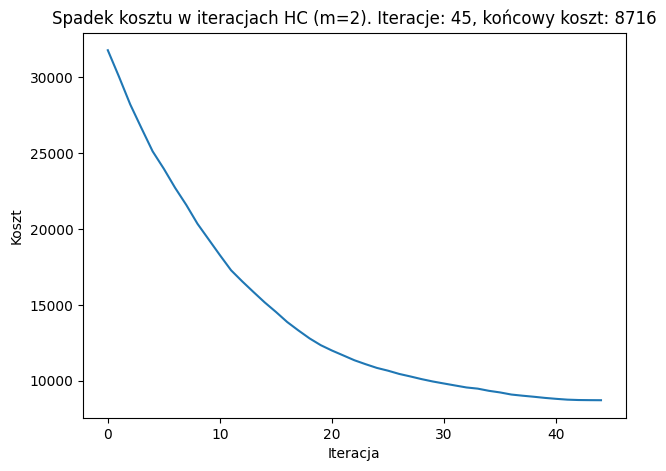

Średni koszt po HC: 8404.8723
Minimum / maksimum kosztu: 7542 9632
Średnia / maksimum iteracji: 46.5404 64


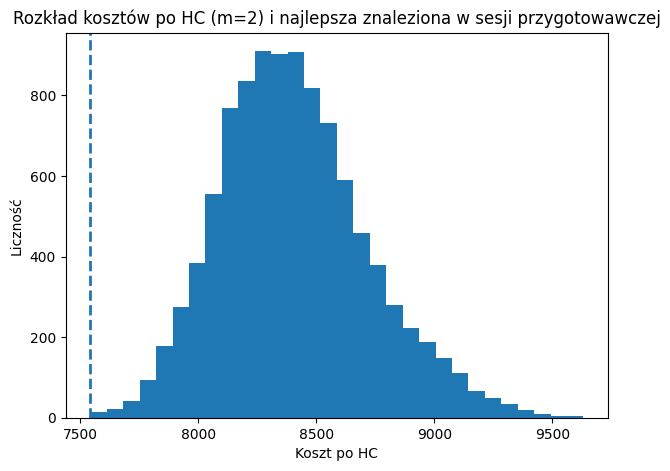

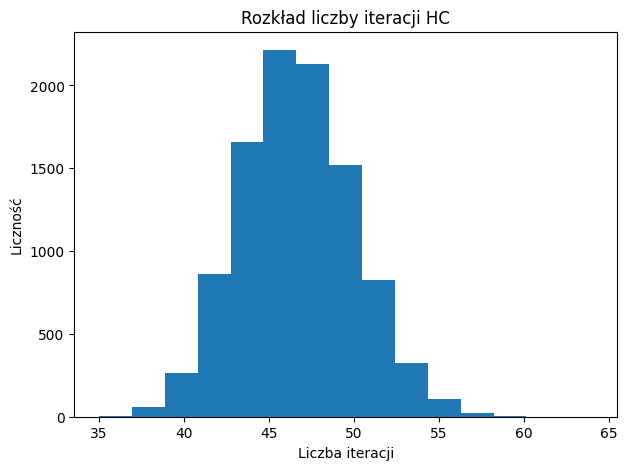

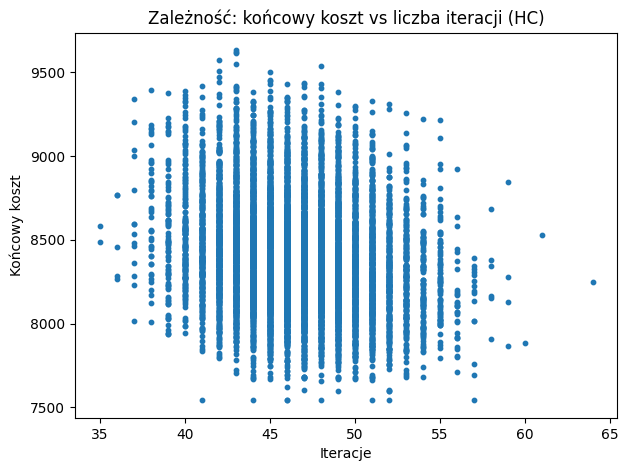

In [35]:
import matplotlib.pyplot as plt

def two_opt_swap(order, i, k):
    return order[:i] + order[i:k+1][::-1] + order[k+1:]

def two_opt_best_improvement(order, D=D):
    best_gain = 0
    best_i = best_k = None
    Nn = len(order)
    for i in range(1, Nn-2):
        a, b = order[i-1], order[i]
        for k in range(i+1, Nn-1):
            c, d = order[k], order[(k+1) % Nn]
            delta = (D[a,c] + D[b,d]) - (D[a,b] + D[c,d])
            if delta < best_gain:
                best_gain = delta
                best_i, best_k = i, k
    if best_gain < 0:
        return two_opt_swap(order, best_i, best_k), best_gain
    else:
        return None, 0

def hc_2opt(order, max_iters=50_000):
    order = order[:]
    it = 0
    while it < max_iters:
        it += 1
        new_order, gain = two_opt_best_improvement(order)
        if new_order is None:
            break
        order = new_order
    return order, tour_cost(order), it

def hc_2opt_with_history(order, max_iters=50_000):
    order = order[:]
    hist = [tour_cost(order)]
    it = 0
    while it < max_iters:
        it += 1
        new_order, gain = two_opt_best_improvement(order)
        if new_order is None:
            break
        order = new_order
        hist.append(hist[-1] + gain)
    return order, tour_cost(order), it, hist

# Przykładowy przebieg
o0 = random_tour()
o1, c1, it1, hist1 = hc_2opt_with_history(o0)

plt.figure(figsize=(7,5))
plt.plot(range(len(hist1)), hist1)
plt.title(f"Spadek kosztu w iteracjach HC (m=2). Iteracje: {it1}, końcowy koszt: {c1}")
plt.xlabel("Iteracja"); plt.ylabel("Koszt"); plt.show()

# Wiele uruchomień
RUNS = 10000  # można zwiększyć
hc_costs = np.zeros(RUNS, dtype=int)
hc_iters = np.zeros(RUNS, dtype=int)
for r in range(RUNS):
    o = random_tour()
    _, c, it = hc_2opt(o, max_iters=50_000)
    hc_costs[r] = c
    hc_iters[r] = it

print("Średni koszt po HC:", float(hc_costs.mean()))
print("Minimum / maksimum kosztu:", int(hc_costs.min()), int(hc_costs.max()))
print("Średnia / maksimum iteracji:", float(hc_iters.mean()), int(hc_iters.max()))

plt.figure(figsize=(7,5))
plt.hist(hc_costs, bins=30)
plt.axvline(tour_cost(optimal_tour), linestyle='--', linewidth=2)
plt.title("Rozkład kosztów po HC (m=2) i najlepsza znaleziona w sesji przygotowawczej")
plt.xlabel("Koszt po HC"); plt.ylabel("Liczność"); plt.show()

plt.figure(figsize=(7,5))
plt.hist(hc_iters, bins=15)
plt.title("Rozkład liczby iteracji HC")
plt.xlabel("Liczba iteracji"); plt.ylabel("Liczność"); plt.show()

plt.figure(figsize=(7,5))
plt.scatter(hc_iters, hc_costs, s=10)
plt.title("Zależność: końcowy koszt vs liczba iteracji (HC)")
plt.xlabel("Iteracje"); plt.ylabel("Końcowy koszt"); plt.show()

In [ ]:
fig_hist.add_trace(go.Scatter(
    y=hist1,
    mode='lines+markers',
    name='Koszt trasy',
    line=dict(width=2),
    marker=dict(size=4)
))

fig_hist.update_layout(
    title='Zbieganie algorytmu Hill Climbing',
    xaxis_title='Iteracja',
    yaxis_title='Koszt trasy',
    template='plotly_white'
)

fig_hist.show()